In [1]:
import sys
sys.path.append("..")
import os
from utils.load_data import load_parquet, load_index, load_csv
from utils.evaultation.generator import Generator
from algo.LSHAlgo import LSH
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score, dcg_score
import math

C:\Users\shrey\anaconda3\envs\SC4020\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ground_truth_path = os.path.abspath('../data/eval/gt/airline_reviews_vsm__type=gt.parquet')
ground_truth = load_parquet(ground_truth_path)
print(f"Number of queries: {ground_truth.shape[0]}")
print(f"Top K: {len(ground_truth['top_k'][0].tolist())}")
ground_truth.head()

Number of queries: 32
Top K: 31


,question,top_k,time_taken
0,"Larnaca to London Heathrow, and wow, British A...",[London Heathrow to Austin with British Airway...,3289
1,LHR-SFO-LHR. Why do I keep thinking BA will im...,[London Heathrow to Austin with British Airway...,1417
2,"British Airways from Gatwick to Catania, Sicil...",[Phoenix to Tel Aviv via London. The return fr...,585
3,British Airways - Travel with Confidence. Prob...,[London Heathrow to Austin with British Airway...,1005
4,What is happening to British Airways? Flew Van...,[London Heathrow to Austin with British Airway...,1127


In [3]:
top_k = 10
runners = []
nbits_config = [2,4,8,16,32,64,128,256,512,768]
for nbits in nbits_config:
    runners.append(lambda nbits=nbits: LSH("airline_reviews", "bge", nbits))
questions = ground_truth["question"].tolist()


In [4]:
generator = Generator(questions, top_k+1)
generator.run(runners)

|████████████████████████████████████████| 320/320 [100%] in 5:22.4 (0.99/s) 


In [5]:
def remove_query_from_predictions(documents, query):
    if query in documents:
        index = documents.index(query)
        documents.pop(index)
    else:
        documents.pop()
    return documents

### Mean Precision@K

In [6]:
output_folder_path = os.path.abspath('../data/eval/2024-09-15_20-33-12/')
num_questions = ground_truth.shape[0]

In [13]:
def get_mean_precision_k(k, num_relevant_docs):
    mean_precision_scores = []
    for nbits in nbits_config:
        df = load_parquet(os.path.join(output_folder_path, f"airline_reviews_lsh__embedding=bge_mode=lsh_similarity_nbits={nbits}.parquet"))
        precision_score = 0
        for i in range(num_questions):
            question = ground_truth["question"][i]
            set1 = set(ground_truth["top_k"][i][1:num_relevant_docs+1])
            set2 = set(remove_query_from_predictions(list(json.loads(df["top_k"][i])["ReviewBody"].values()), question)[0:k])
            true_positive = len(set1.intersection(set2))
            precision_score += true_positive/k
        mean_precision_scores.append(precision_score/num_questions)
    return mean_precision_scores

Mean Precision@3, Mean Precision@5, Mean Precision@10

In [14]:
mean_precision_score_at_3 = get_mean_precision_k(3,10)
mean_precision_score_at_5 = get_mean_precision_k(5,10)
mean_precision_score_at_10 = get_mean_precision_k(10,10)

In [15]:
df = pd.DataFrame({
    'nbits_config': nbits_config,
    'Mean Average Precision@3': mean_precision_score_at_3,
    'Mean Average Precision@5': mean_precision_score_at_5,
    'Mean Average Precision@10': mean_precision_score_at_10
})
df

,nbits_config,Mean Average Precision@3,Mean Average Precision@5,Mean Average Precision@10
0,2,0.000000,0.00000,0.000000
1,4,0.000000,0.00000,0.009375
2,8,0.000000,0.01875,0.021875
3,16,0.062500,0.03750,0.034375
4,32,0.031250,0.02500,0.028125
5,64,0.135417,0.10000,0.084375
6,128,0.135417,0.12500,0.103125
7,256,0.239583,0.20625,0.162500
8,512,0.395833,0.33750,0.309375
9,768,0.583333,0.53125,0.418750


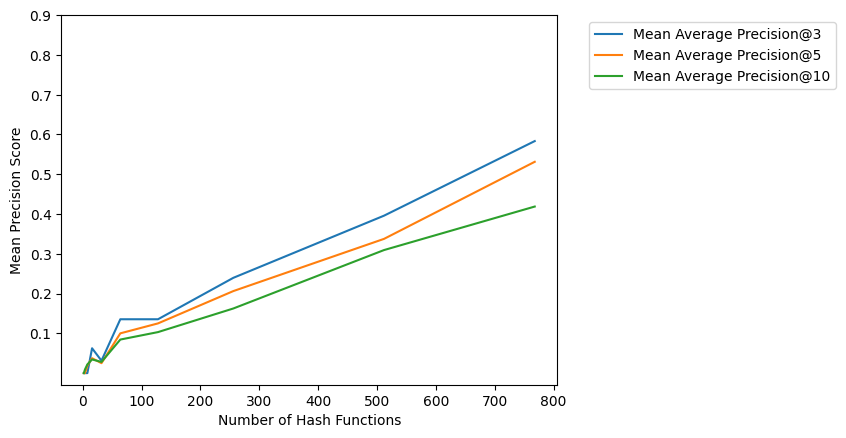

In [16]:
plt.plot(nbits_config, mean_precision_score_at_3, label="Mean Average Precision@3")
plt.plot(nbits_config, mean_precision_score_at_5, label="Mean Average Precision@5")
plt.plot(nbits_config, mean_precision_score_at_10, label="Mean Average Precision@10")

plt.xlabel("Number of Hash Functions")
plt.ylabel("Mean Precision Score")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

### Mean Reciprocal Rank@K

In [17]:
def get_reciprocal_rank(most_relevant_document, predictions):
    try:
        rank = predictions.index(most_relevant_document)+1
        return 1.0/rank
    except ValueError:
        return 0.0

In [20]:
def get_mean_reciprocal_rank(k):
    mean_reciprocal_ranks = []
    for nbits  in nbits_config:
        df = load_parquet(os.path.join(output_folder_path, f"airline_reviews_lsh__embedding=bge_mode=lsh_similarity_nbits={nbits}.parquet"))
        reciprocal_rank = 0
        for i in range(num_questions):
            question = ground_truth["question"][i]
            most_relevant_document = ground_truth["top_k"][i][1]
            predictions = remove_query_from_predictions(list(json.loads(df["top_k"][i])["ReviewBody"].values()), question)[0:k]
            reciprocal_rank += get_reciprocal_rank(most_relevant_document, predictions)
        mean_reciprocal_ranks.append(reciprocal_rank/num_questions)
    return mean_reciprocal_ranks

In [21]:
mean_reciprocal_ranks_at_1 = get_mean_reciprocal_rank(1)
mean_reciprocal_ranks_at_3 = get_mean_reciprocal_rank(3)
mean_reciprocal_ranks_at_5 = get_mean_reciprocal_rank(5)
mean_reciprocal_ranks_at_10 = get_mean_reciprocal_rank(10)

In [22]:
df = pd.DataFrame({
    'nbits_config': nbits_config,
    'Mean Reciprocal Rank@1': mean_reciprocal_ranks_at_1,
    'Mean Reciprocal Rank@3': mean_reciprocal_ranks_at_3,
    'Mean Reciprocal Rank@5': mean_reciprocal_ranks_at_5,
    'Mean Reciprocal Rank@10': mean_reciprocal_ranks_at_10
})
df

,nbits_config,Mean Reciprocal Rank@1,Mean Reciprocal Rank@3,Mean Reciprocal Rank@5,Mean Reciprocal Rank@10
0,2,0.00000,0.000000,0.000000,0.000000
1,4,0.00000,0.000000,0.000000,0.000000
2,8,0.00000,0.000000,0.000000,0.000000
3,16,0.00000,0.015625,0.015625,0.015625
4,32,0.00000,0.000000,0.000000,0.003125
5,64,0.03125,0.031250,0.045312,0.054985
6,128,0.00000,0.015625,0.035937,0.035937
7,256,0.06250,0.093750,0.101562,0.110243
8,512,0.12500,0.229167,0.251042,0.297507
9,768,0.21875,0.328125,0.342188,0.373772


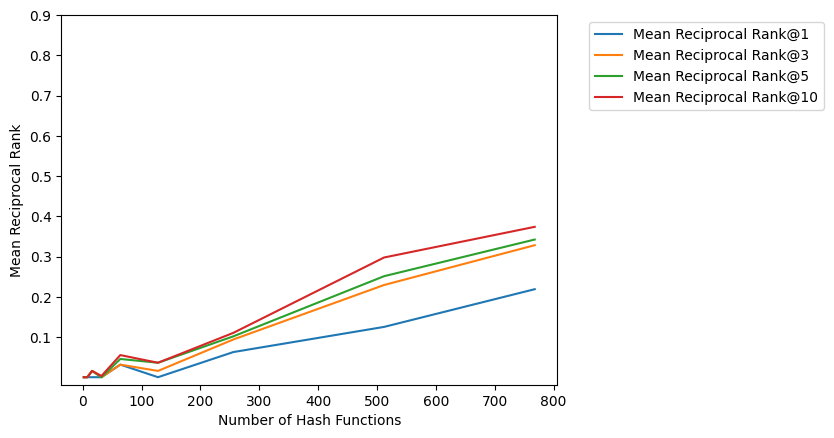

In [23]:
plt.plot(nbits_config, mean_reciprocal_ranks_at_1, label="Mean Reciprocal Rank@1")
plt.plot(nbits_config, mean_reciprocal_ranks_at_3, label="Mean Reciprocal Rank@3")
plt.plot(nbits_config, mean_reciprocal_ranks_at_5, label="Mean Reciprocal Rank@5")
plt.plot(nbits_config, mean_reciprocal_ranks_at_10, label="Mean Reciprocal Rank@10")

plt.xlabel("Number of Hash Functions")
plt.ylabel("Mean Reciprocal Rank")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

### Mean Normalised Discounted Cumulative Gain@K

In [24]:
def compute_relevance_scores(ground_truth, predictions):
    relevance_map = {doc: len(ground_truth) - score for score, doc in enumerate(ground_truth)}
    scores = [relevance_map.get(doc,0) for doc in predictions]
    return scores

In [25]:
def get_mean_ndcg_k(k):
    mean_ndcgs = []
    for nbits in nbits_config:
        df = load_parquet(os.path.join(output_folder_path, f"airline_reviews_lsh__embedding=bge_mode=lsh_similarity_nbits={nbits}.parquet"))
        ndcg = 0
        for i in range(num_questions):
            question = ground_truth["question"][i]
            relevance_score = compute_relevance_scores(ground_truth["top_k"][i][1:k+1], remove_query_from_predictions(list(json.loads(df["top_k"][i])["ReviewBody"].values()), question)[0:k])
            true_relevance = list(range(k,0,-1)) 
            idcg = 0
            dcg = 0
            for i in range(len(relevance_score)):
                # formula
                idcg += true_relevance[i] / math.log(i+2,2)
                dcg += relevance_score[i] / math.log(i+2,2)
            ndcg += dcg/idcg
        mean_ndcgs.append(ndcg/num_questions)
    return mean_ndcgs

In [26]:
mean_normalised_dcgs_at_3 = get_mean_ndcg_k(3)
mean_normalised_dcgs_at_5 = get_mean_ndcg_k(5)
mean_normalised_dcgs_at_10 = get_mean_ndcg_k(10)

In [27]:
df = pd.DataFrame({
    'nbits_config': nbits_config,
    'Mean Normalised DCG@3': mean_normalised_dcgs_at_3,
    'Mean Normalised DCG@5': mean_normalised_dcgs_at_5,
    'Mean Normalised DCG@10': mean_normalised_dcgs_at_10
})
df

,nbits_config,Mean Normalised DCG@3,Mean Normalised DCG@5,Mean Normalised DCG@10
0,2,0.000000,0.000000,0.000000
1,4,0.000000,0.000000,0.004440
2,8,0.000000,0.001177,0.015367
3,16,0.012422,0.024809,0.044164
4,32,0.003281,0.004563,0.021390
5,64,0.036250,0.054483,0.088580
6,128,0.046249,0.066253,0.092432
7,256,0.102890,0.125906,0.175615
8,512,0.257733,0.259553,0.349080
9,768,0.366719,0.397597,0.471549


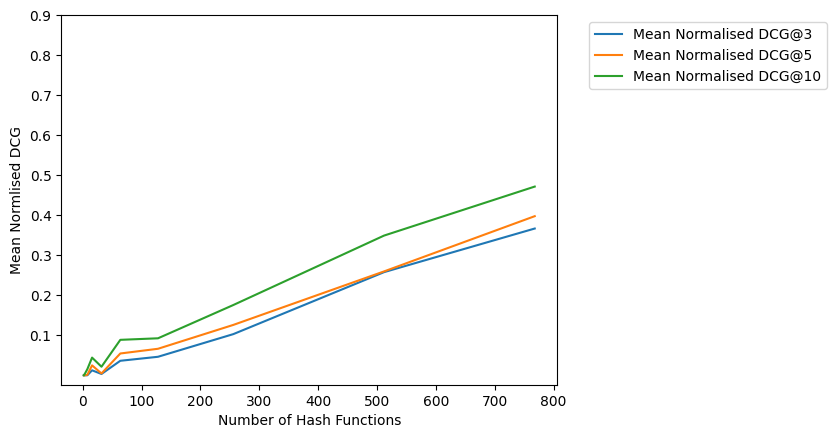

In [28]:
plt.plot(nbits_config, mean_normalised_dcgs_at_3, label="Mean Normalised DCG@3")
plt.plot(nbits_config, mean_normalised_dcgs_at_5, label="Mean Normalised DCG@5")
plt.plot(nbits_config, mean_normalised_dcgs_at_10, label="Mean Normalised DCG@10")

plt.xlabel("Number of Hash Functions")
plt.ylabel("Mean Normlised DCG")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()